# Data preprocessing

In this notebook I bring together Airbnb listing data and NYC open data sources to quantify the urban environment around each listing. 

I geolocate each data point from the various sources, and assign each listing its "urban context" within a 0.25 mile buffer. 

Finally, I process each listing's landing image to calculate its brightness level.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from descartes import PolygonPatch
import warnings
from IPython.display import clear_output
from IPython import display
import time
import random
from PIL import Image, ImageStat
from io import BytesIO
import math
random.seed(11)

%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'display', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

tableau10 = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
for i in range(len(tableau10)):  
    r, g, b = tableau10[i]  
    tableau10[i] = (r / 255., g / 255., b / 255.)
    
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# plt.rcParams['font.serif'] = 'Arial'
# plt.rcParams['font.family'] = "sans-serif"
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load data
Loading NYC airbnb listings, subway stop and grocery store locations, and 311 noise complaints between November 2018 and Januuary 2019.

In [4]:
# load airbnb
df = pd.read_csv(r'../data/airbnb_listings.csv')

# load NYC open data
noise = pd.read_csv(r'../data/311noise_nov_jan.csv')
groc = pd.read_csv(r'../data/Retail_Food_Stores.csv')
sub = pd.read_csv(r'../data/DOITT_SUBWAY_STATION_01_13SEPT2010.csv')

FileNotFoundError: File b'../data/airbnb_listings.csv' does not exist

Remove listings that are no longer available (as of January 25th).

In [ ]:
# def noLongerAvail(url):
#     """ 
#     Flag listings that are no longer available on airbnb. 
  
#     Parameters: 
#     url: URL of the listing
  
#     Returns: 
#     1 if listing not available, 0 otherwise.
  
#     """
#     page = requests.get(url)
#     soup = BeautifulSoup(page.content, "html.parser")
#     if soup.title.string == u'Vacation Rentals, Homes, Experiences & Places - Airbnb':
#         return 1
#     else:
#         return 0
    
# df['flag_noLongerAvail'] = df.listing_url.apply(noLongerAvail)

In [ ]:
# print ('Ratio of no longer available listings over total:', df.flag_noLongerAvail.sum()/float(len(df))

Plot all Airbnb listings.

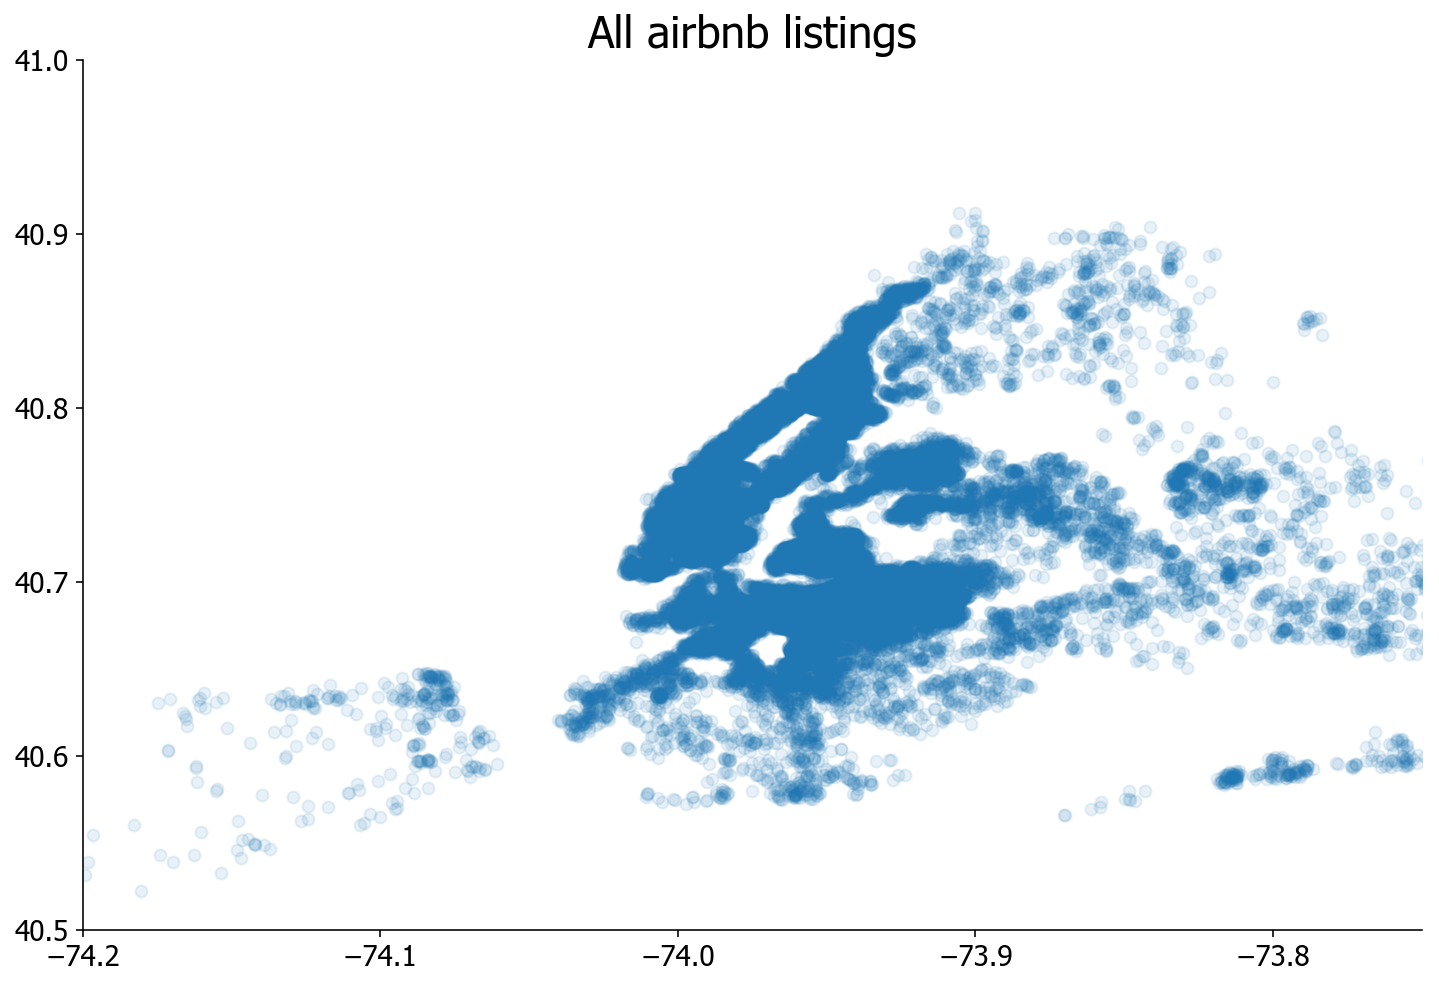

In [4]:
# Visualize the airbnb listings
plt.scatter(df.longitude, df.latitude, alpha=.1)
plt.title('All airbnb listings')
plt.ylim(40.5,41)
plt.xlim(-74.2, -73.75)
plt.show()

## Process data
Process the data location features to convert it in (longitude, latitude) tuples. For the Airbnb listings I also create a 1/4 mile buffer around the listing to spatially join the data later.

Airbnb listings

In [42]:
# Convert lat/lon to shapely point
df['Coordinates'] = list(zip(df.longitude, df.latitude))
df['Coordinates'] = df['Coordinates'].apply(Point)

# Convert coordinates
dfGeo = gpd.GeoDataFrame(df, crs={'init' :'epsg:4326'}, geometry='Coordinates')

# Create the 1/4 mile buffer
count=0
buffers = []
start = time.time()

for point in dfGeo.Coordinates:
    try:
        buffers.append(point.buffer(402.3/111320.0)) #402.3 meters
    except:
        buffers.append(np.nan)
    
    count += 1
    if count in np.arange(0,49000,100):
        clear_output()
        print ('Completed %s evaluations'%count)

dfGeo['buffer_quarterMile'] = buffers

print ('It took', time.time()-start, 'seconds.')

Completed 48900 evaluations
It took 10.571802854537964 seconds.


311 noise complaints

In [8]:
# convert to shapely points
noise['Coordinates'] = list(zip(noise.Longitude, noise.Latitude))
noise['Coordinates'] = noise['Coordinates'].apply(Point)

Grocery stores

In [9]:
# filter grocery stores located in NYC
nycCounties = ['New York', 'Kings', 'Richmond', 'Bronx', 'Queens']
groc = groc[groc.County.isin(nycCounties)]
print(groc.shape)

# flag the ones where location is missing
groc['flag_MissingLocation'] = groc.Location.apply(lambda x: 0 if x==x else 1)
groc = groc[groc.flag_MissingLocation==0]
print (groc.shape)

# clean address information and bring to right format for geocoding
groc['Street Number'] = groc['Street Number'].apply(lambda x:str(x))
groc['Street Name'] = groc['Street Name'].apply(lambda x:str(x))
groc['Zip Code'] = groc['Zip Code'].apply(lambda x:str(x))
groc['Address'] = groc['Street Number'] + groc['Street Name'] + ',' + groc['City'] + groc['State'] + groc['Zip Code']

def cleanAddress(x):
    """ 
    Converts address to its proper format for geocoding
  
    Parameters: 
    x: dataframe including street name, number, state and zip code
  
    Returns: 
    address: address string ready for geocoding
  
    """
    
    streetNum = x['Street Number'].rstrip()
    streetName = x['Street Name'].rstrip()
    city = x['City'].rstrip()
    state = x['State'].rstrip()
    zipCode = x['Zip Code'].rstrip()
    return streetNum + ' ' + streetName + ' ' + city + ' ' + state + ' ' + zipCode

groc['Address'] = groc.apply(cleanAddress, axis=1)

(14233, 15)

In [63]:
# start = time.time()

# # initialize geocoder
# geolocator = Nominatim()
# #set min_delay to 1sec so the API doesn't block you
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
# # geocode address
# groc['location'] = groc['Address'].apply(geocode)
# groc['point'] = groc['location'].apply(lambda loc: tuple(loc.point) if loc else None)

# print ('It took', time.time()-start, 'seconds.')
# #convert to shapely points
# groc['Coordinates'] = list(zip(groc.lon, groc.lat))
# groc['Coordinates'] = groc['Coordinates'].apply(Point)

# groc = groc[groc.point==groc.point]
# groc.shape

RateLimiter caught an error, retrying (0/2 tries). Called with (*('401 SCHENECTADY AVE BROOKLYN NY 11213',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1

RateLimiter caught an error, retrying (0/2 tries). Called with (*('473 52ND ST BROOKLYN NY 11220',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, in 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('448 W 16TH ST NEW YORK NY 10011',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, i

RateLimiter caught an error, retrying (0/2 tries). Called with (*('38 W 14TH ST NEW YORK NY 10011',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, in

RateLimiter caught an error, retrying (0/2 tries). Called with (*('43-21 BEACH CHANNEL DR FAR ROCKAWAY NY 11691',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py",

RateLimiter caught an error, retrying (0/2 tries). Called with (*('137-20 CROSSBAY BLVD OZONE PARK NY 11417',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", lin

RateLimiter caught an error, retrying (0/2 tries). Called with (*('79-15 ELIOT AVE MIDDLE VILLAGE NY 11379',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line

RateLimiter caught an error, retrying (0/2 tries). Called with (*('37-20 BROADWAY ASTORIA NY 11103',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, i

RateLimiter caught an error, retrying (0/2 tries). Called with (*('59-59 69TH ST MASPETH NY 11378',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, in

RateLimiter caught an error, retrying (0/2 tries). Called with (*('98-88 QUEENS BLVD REGO PARK NY 11374',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 14

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1500 CASTLE HILL AVENUE BRONX NY 10462',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1331, in getresponse
    response.

RateLimiter caught an error, retrying (0/2 tries). Called with (*('2664 GRAND CONCOURSE BRONX NY 10458',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 140

RateLimiter caught an error, retrying (0/2 tries). Called with (*('809 SOUTHERN BLVD BRONX NY 10459',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('481 E 180TH ST BRONX NY 10457',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1392, in 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('4643 THIRD AVE BRONX NY 10458',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1392, in 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('82 W 165TH STREET BRONX NY 10452',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('12 WEST 183RD ST BRONX NY 10453',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, i

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1135 HOE AVE BRONX NY 10459',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, in co

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1055 FLUSHING AVE BROOKLYN NY 11237',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 140

RateLimiter caught an error, retrying (0/2 tries). Called with (*('437 DEKALB AVE BROOKLYN NY 11205',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('34 35TH STREET 6TH FL BROOKLYN NY 11232',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line

RateLimiter caught an error, retrying (0/2 tries). Called with (*('67 WEST ST SUITE 330 BROOKLYN NY 11222',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('218 BROADWAY BROOKLYN NY 11211',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()


RateLimiter caught an error, retrying (0/2 tries). Called with (*('5613 8TH AVE BROOKLYN NY 11220',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, in

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1603 AVENUE U BROOKLYN NY 11229',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, i

RateLimiter caught an error, retrying (0/2 tries). Called with (*('205 CHURCH AVE BROOKLYN NY 11218',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('889 BROADWAY BROOKLYN NY 11206',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, in

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1368 LORING AVE BROOKLYN NY 11208',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400,

RateLimiter caught an error, retrying (0/2 tries). Called with (*('188 9TH AVE NEW YORK NY 10011',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, in 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('815 10TH AVENUE NEW YORK NY 10019',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400,

RateLimiter caught an error, retrying (0/2 tries). Called with (*('500 HUDSON STREET NEW YORK NY 10014',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 140

RateLimiter caught an error, retrying (1/2 tries). Called with (*('149 SULLIVAN ST NEW YORK NY 10012',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400,

RateLimiter caught an error, retrying (1/2 tries). Called with (*('127 LUDLOW ST NEW YORK NY 10002',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1392, i

RateLimiter caught an error, retrying (1/2 tries). Called with (*('110 FORSYTH ST NEW YORK NY 10002',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, 

RateLimiter caught an error, retrying (1/2 tries). Called with (*('1460 ST NICHOLAS AVE NEW YORK NY 10033',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 

RateLimiter caught an error, retrying (1/2 tries). Called with (*('79 ALLEN ST UNIT B NEW YORK NY 10002',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 14

RateLimiter caught an error, retrying (1/2 tries). Called with (*('2840 BROADWAY NEW YORK NY 10025',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1392, i

RateLimiter caught an error, retrying (1/2 tries). Called with (*('1637 YORK AVE NEW YORK NY 10028',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1392, i

RateLimiter caught an error, retrying (0/2 tries). Called with (*('873 BROADWAY NEW YORK NY 10003',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()


RateLimiter caught an error, retrying (0/2 tries). Called with (*('2450 AMSTERDAM AVE NEW YORK NY 10033',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 13

RateLimiter caught an error, retrying (0/2 tries). Called with (*('129 POST AVE NEW YORK NY 10034',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1392, in

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1606 AMSTERDAM AVE NEW YORK NY 10031',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 13

RateLimiter caught an error, retrying (1/2 tries). Called with (*('47 PITT ST NEW YORK NY 10002',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1392, in c

RateLimiter caught an error, retrying (1/2 tries). Called with (*('1749 1ST AVE NEW YORK NY 10128',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1392, in

RateLimiter caught an error, retrying (1/2 tries). Called with (*('221 W 28TH ST NEW YORK NY 10001',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, i

RateLimiter caught an error, retrying (1/2 tries). Called with (*('2079 7TH AVE NEW YORK NY 10027',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1392, in

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1471 BROADWAY NEW YORK NY 10036',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()

RateLimiter caught an error, retrying (0/2 tries). Called with (*('226 E 7TH STREET NEW YORK NY 10009',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begi

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1031 1ST AVE NEW YORK NY 10022',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400, in

RateLimiter caught an error, retrying (0/2 tries). Called with (*('29-15 21ST AVENUE ASTORIA NY 11105',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400

RateLimiter caught an error, retrying (0/2 tries). Called with (*('25-01 ASTORIA BLVD ASTORIA NY 11102',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 140

RateLimiter caught an error, retrying (0/2 tries). Called with (*('680 BAY ST STATEN ISLAND NY 10304',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1400,

RateLimiter caught an error, retrying (1/2 tries). Called with (*('4174 VICTORY BLVD STATEN ISLAND NY 10314',), **{}).
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda/envs/py36/lib/python3.6/http/client.py", line 1331, in getresponse
    respons

It took 25916.676808834076 seconds.


Subway stops

In [15]:
# convert lat/lon to shapely points
sub['lat'] = sub.the_geom.apply(lambda x: float(x.split(' ')[2][:-1]))
sub['lon'] = sub.the_geom.apply(lambda x: float(x.split(' ')[1][1:]))
sub['Coordinates'] = list(zip(sub.lon, sub.lat))

sub['Coordinates'] = sub['Coordinates'].apply(Point)

# load as a geo dataframe
sub = gpd.GeoDataFrame(sub, geometry='Coordinates')

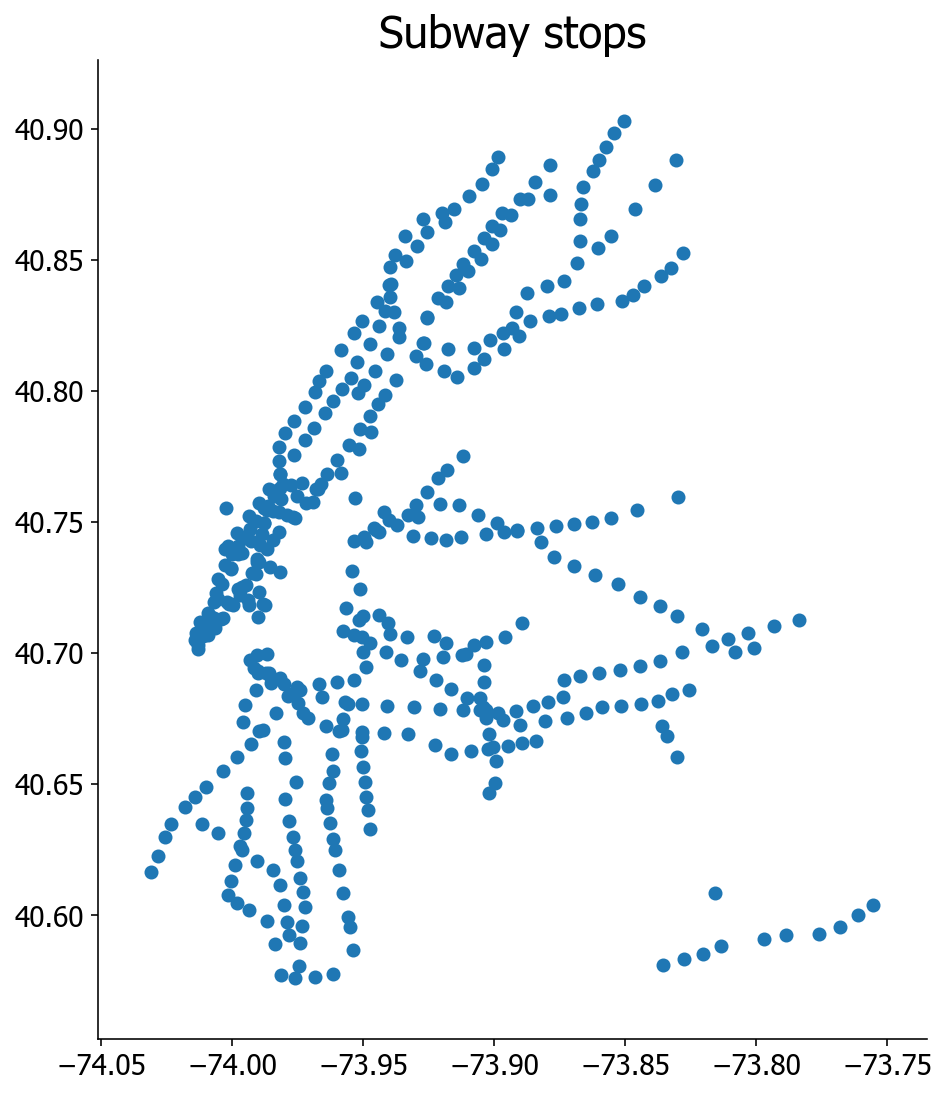

In [61]:
# visualize subway stops
sub.plot(figsize=(9,9))
plt.title('Subway stops')
plt.show()

## Spatial join the datasets
See what location characteristics fall inside each listing's buffer.

In [287]:
# closeSubway = []
# start = time.time()
# counter = 0
# for listing in dfGeo['buffer_quarterMile']:
#     count=0
#     for station in sub.Coordinates:
#         try:
#             if listing.contains(station):
#                 count+=1
#         except:
#             continue
#     closeSubway.append(count)
    
#     counter += 1
#     if counter in np.arange(0,49000,500):
#         clear_output()
#         print ('Completed %s evaluations'%counter)

# print ('It took', time.time()-start, 'seconds.')

# dfGeo['closeSubway'] = closeSubway

Completed 48500 evaluations
It took 117.74591517448425 seconds.


In [293]:
# closeGrocery = []
# start = time.time()
# counter = 0
# for listing in dfGeo['buffer_quarterMile']:
#     count=0
#     for store in groc.Coordinates:
#         try:
#             if listing.contains(store):
#                 count+=1
#         except:
#             continue
#     closeGrocery.append(count)
    
#     counter += 1
#     if counter in np.arange(0,49000,100):
#         clear_output()
#         print ('Completed %s evaluations'%counter)

# print ('It took', time.time()-start, 'seconds.')

# dfGeo['closeGrocery'] = closeGrocery

Completed 48900 evaluations
It took 2789.8146669864655 seconds.


In [45]:
# closeNoise = []
# start = time.time()
# counter = 0

# for listing in dfGeo['buffer_quarterMile']:
#     count=0
#     for noi in noise.Coordinates:
#         try:
#             if listing.contains(noi):
#                 count+=1
#         except:
#             continue
#     closeNoise.append(count)
    
#     counter += 1
#     if counter in np.arange(0,49000,10):
#         clear_output()
#         print ('Completed %s evaluations'%counter)

# print ('It took', time.time()-start, 'seconds.')

# dfGeo['closeNoise'] = closeNoise

Completed 48990 evaluations
It took 23605.899979114532 seconds.


## A sample of listings with their urban context
Here I provide an example of how I geolocate and spatially join the urban data in this notebook.

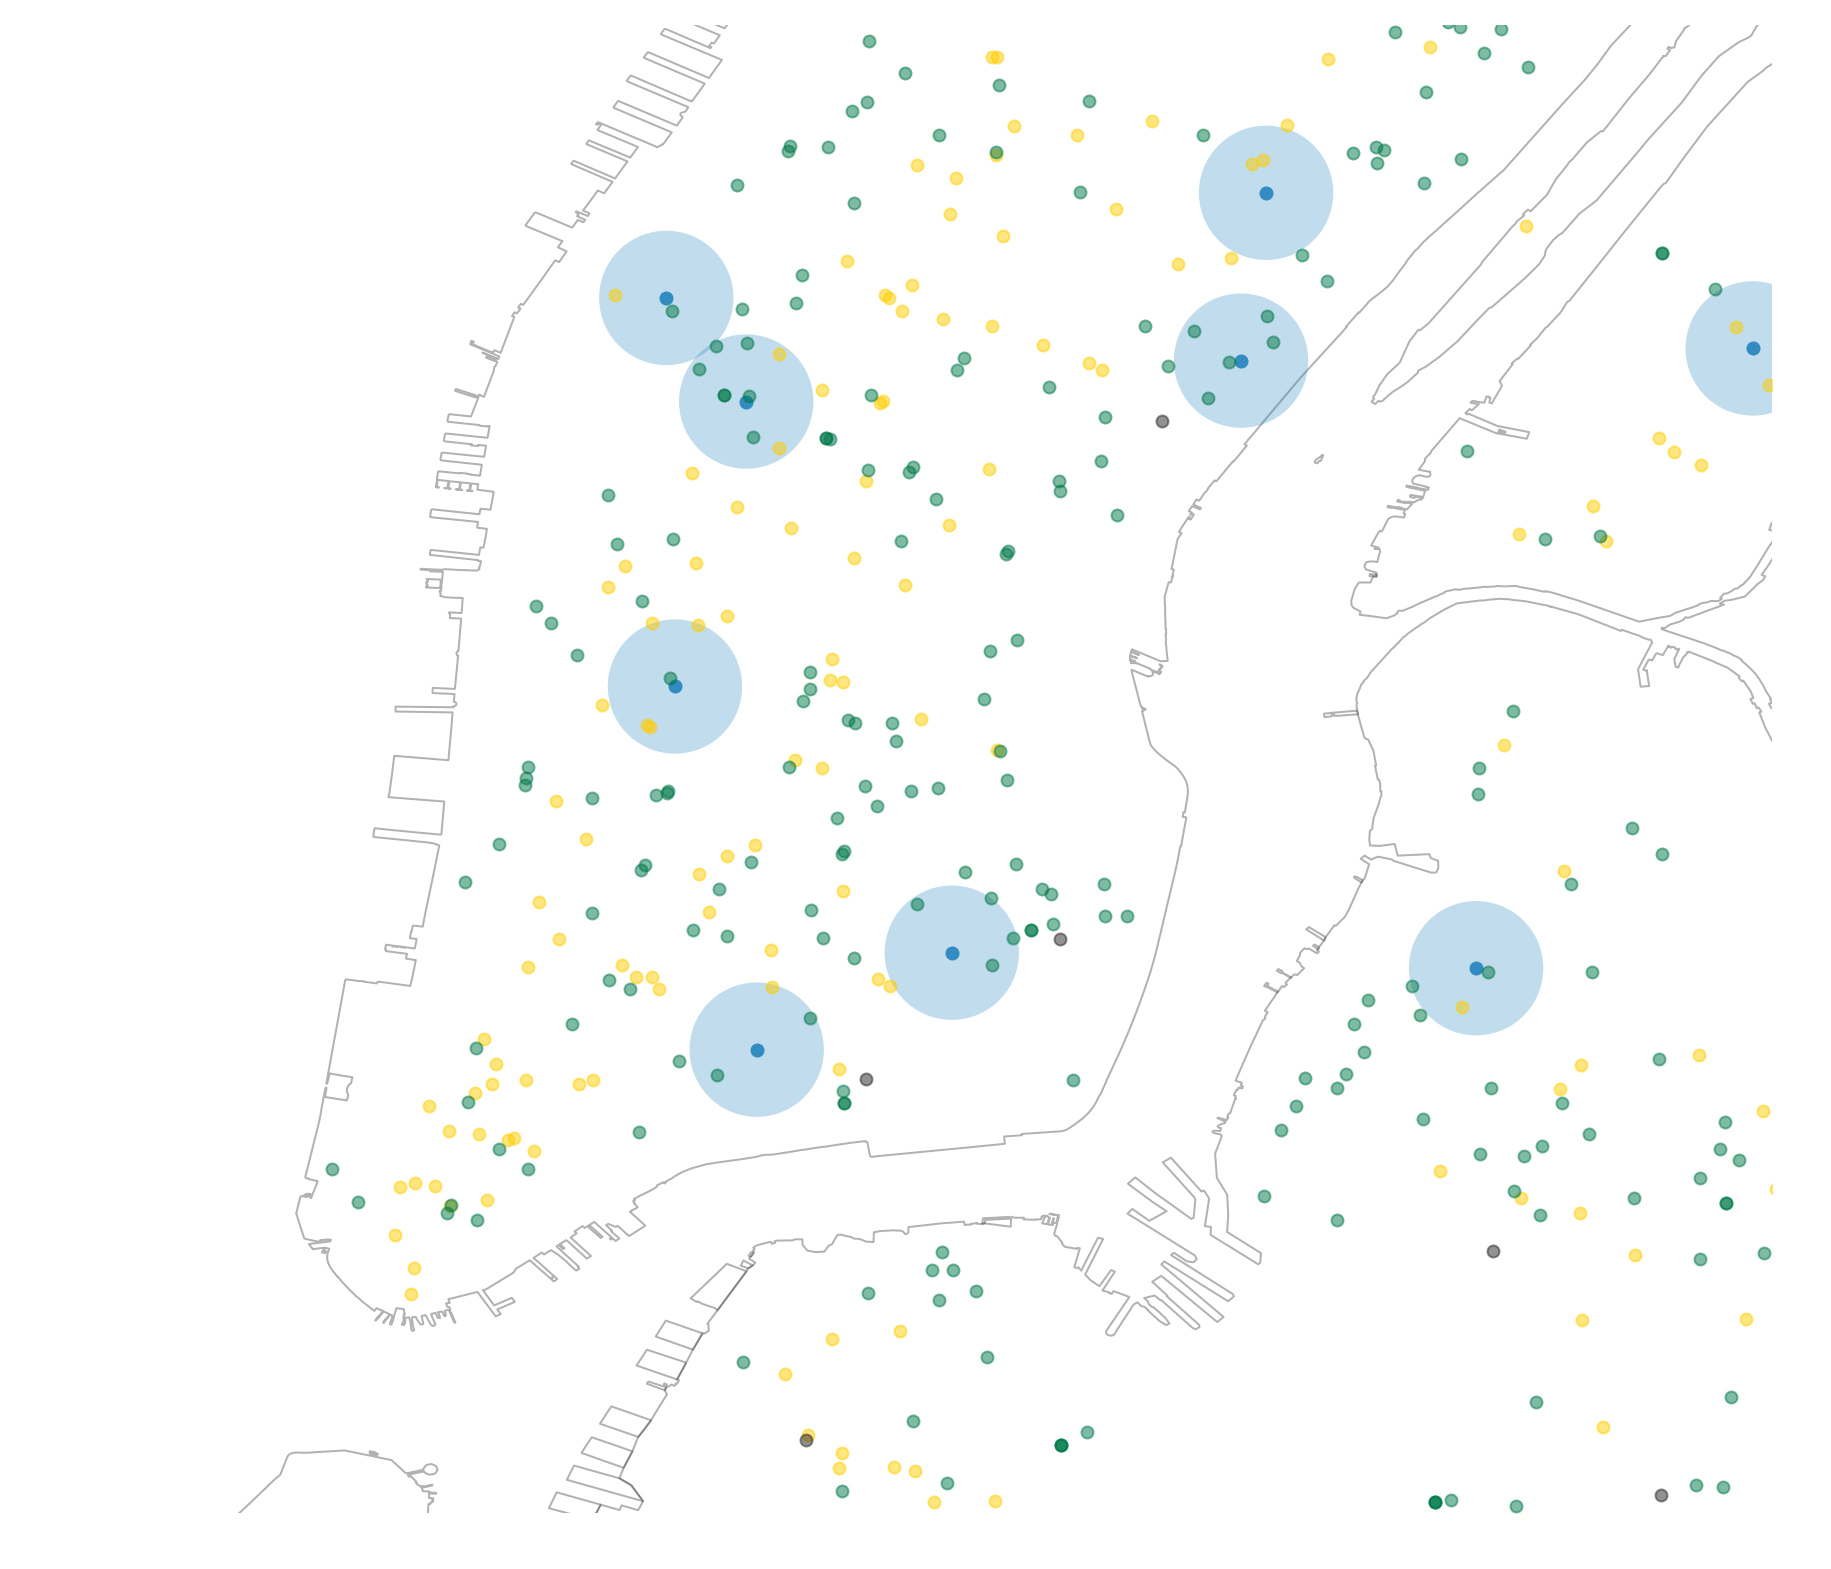

In [26]:
state = 11

# load NYC basemap
nycBase = gpd.read_file(gpd.datasets.get_path('nybb'))
nycBase.crs = from_epsg(2263)
nycBase = nycBase.to_crs(epsg=4326)

foo = df.sample(n=20, random_state = state)
geom = [Point(xy) for xy in zip(foo.longitude, foo.latitude)]
buf = [Point(xy).buffer(402.3/111320.0) for xy in zip(foo.longitude, foo.latitude)]
geom = gpd.GeoDataFrame(pd.DataFrame({'geometry': geom}))
buf = gpd.GeoDataFrame(pd.DataFrame({'geometry': buf}))

noiseGeo = gpd.GeoDataFrame(noise.sample(n=1000, random_state = state))
noiseGeo['geometry'] = noiseGeo.Coordinates

grocGeo = gpd.GeoDataFrame(groc.sample(n=1000, random_state = state))
grocGeo['geometry'] = grocGeo.Coordinates

col1 = "#328cc1"
col2 = "#ffce00"
col3 = "#007849"
col4 = "#262228"

fig, ax = plt.subplots(figsize=(15,15))
nycBase.plot(alpha=0.3, color='white', edgecolor='k', ax=ax)
geom.plot(ax=ax, color=col1)
buf.plot(ax=ax, alpha=.3, color='#328cc1')
sub.plot(ax=ax, alpha=.5, color=col2)
noiseGeo.plot(ax=ax, color=col3, alpha=.5)
grocGeo.plot(ax=ax, color=col4, alpha=.5)
plt.xlim(-74.03, -73.94)
plt.ylim(40.69, 40.77)
plt.axis('off')
plt.savefig(r'../output/sample_buffer_color.png')
plt.show()

## Get image brightness
Extract the image listing brightness level, as well indivudual color red, green, blue (RGB) brightness. 

The image brightness information will be later used in the price modeling algorithm. The hypothesis is that brighter images (more professional also?) predespose user to have a positive attitude towards the listing, which potentially can lead to willingness to pay more.

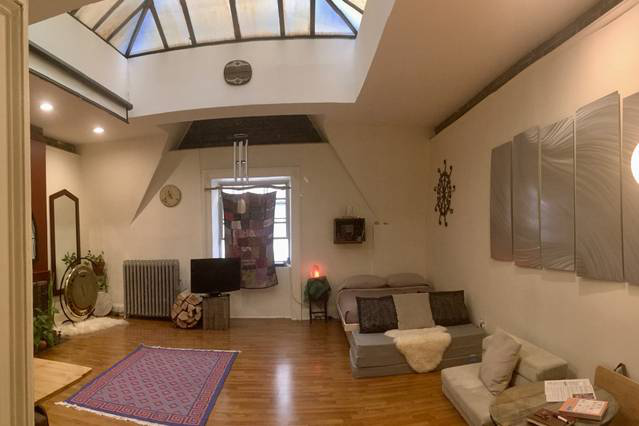

In [11]:
# example image
response = requests.get(df.picture_url[3])
img = Image.open(BytesIO(response.content))
img

In [ ]:
def getImageData(url):
    """ 
    Extracts image brightness.
  
    Parameters: 
    url: url pointing to the airbnb listing image
  
    Returns: 
    r: decimal code for red color
    g: decimal code for green color
    b: decimal code for blue color
    bright: image brightness
  
    """
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        stat = ImageStat.Stat(img)
        r,g,b = stat.rms
        bright = math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))
        return r, g, b, bright
    except:
        return np.nan
    
dfGeo['imageInfo'] = dfGeo.picture_url.apply(getImageData)

## Save data for modeling

In [ ]:
# export data to csv
dfGeo.to_csv(r'../data/airbnb-fullUrbanFeats_img.csv')